### Assignment 7 - Unsupervised Machine Learning Techniques Assignment II

### Author: jd3631 Chloe Du

This week, I will continue exploring 'Inpatient Charges' dataset. As shown in previous projects, this dataset is tidy and we have created enough features, so this week I will mainly focus on trying anther two algorithms in PyOD (Autoencoder and iForest), then I will inspect the summary statistics to extract some insights about the anomalies.

#### Remember:
To detect the anomolies, we mainly focus on finding out the unusually high total discharges or cost of treatments to see if there are abuse or wastes.

#### Review the Healthcare dataset
This part is the same as the previous

In [248]:
#import necessary libraries
import numpy as np 
import pandas as pd

from scipy import stats  #for some statistics
from scipy.stats import norm, skew


import matplotlib.pyplot as plt # for visulisation
import seaborn as sns
color = sns.color_palette()
sns.set_style('whitegrid')
%matplotlib inline

import warnings 
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn  #ignore warnings (from sklearn and seaborn)

In [249]:
# Now to import and put the dataset 
df = pd.read_csv("/Users/jiayangdu/Desktop/Columbia University /APAN 5420/inpatientCharges.csv")
df.shape
# This original dataset has 163,065 rows and 12 columns

(163065, 12)

In [250]:
#something wrong with the columns, some are not callable, so I just rename them
df.columns= ['DRG Definition','Provider Id','Provider Name','Provider Street Address','Provider City','Provider State','Provider Zip Code','Hospital Referral Region Description','Total Discharges','Average Covered Charges($)','Average Total Payments($)','Average Medicare Payments($)']
# convert datatype
df['Provider Id'] = df['Provider Id'].apply(lambda x:str(x))
df['Provider Zip Code'] = df['Provider Zip Code'].apply(lambda x:str(x))

num_cols = ['Average Covered Charges($)','Average Total Payments($)','Average Medicare Payments($)']
df[num_cols] = df[num_cols].replace({'\$':''}, regex = True)
df['Average Covered Charges($)'] = df['Average Covered Charges($)'].apply(lambda x:float(x))
df['Average Total Payments($)'] = df['Average Total Payments($)'].apply(lambda x:float(x))
df['Average Medicare Payments($)'] = df['Average Medicare Payments($)'].apply(lambda x:float(x))
# since the DRG Definition is too long, to make everything easy, we just extract the code from each DRG Definition 
df['DRG Code'] = df['DRG Definition'].apply(lambda x:x.split('-')[0])

In [251]:
#Take a quick look at some basic categorical data
df.describe(include=['O'])

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,DRG Code
count,163065,163065,163065,163065,163065,163065,163065,163065,163065
unique,100,3337,3201,3326,1977,51,3053,306,100
top,194 - SIMPLE PNEUMONIA & PLEURISY W CC,100220,GOOD SAMARITAN HOSPITAL,100 MEDICAL CENTER DRIVE,CHICAGO,CA,76104,CA - Los Angeles,194
freq,3023,100,633,183,1505,13064,317,3653,3023


In [252]:
df.describe()

,Total Discharges,Average Covered Charges($),Average Total Payments($),Average Medicare Payments($)
count,163065.000000,163065.000000,163065.000000,163065.000000
mean,42.776304,36133.954224,9707.473804,8494.490964
std,51.104042,35065.365931,7664.642598,7309.467261
min,11.000000,2459.400000,2673.000000,1148.900000
25%,17.000000,15947.160000,5234.500000,4192.350000
50%,27.000000,25245.820000,7214.100000,6158.460000
75%,49.000000,43232.590000,11286.400000,10056.880000
max,3383.000000,929118.900000,156158.180000,154620.810000


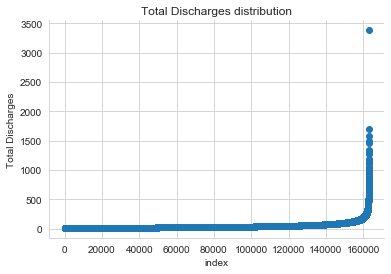

In [253]:
## have a general look at the outliers
plt.scatter(range(df.shape[0]), np.sort(df['Total Discharges'].values))
plt.xlabel('index')
plt.ylabel('Total Discharges')
plt.title("Total Discharges distribution")
sns.despine()

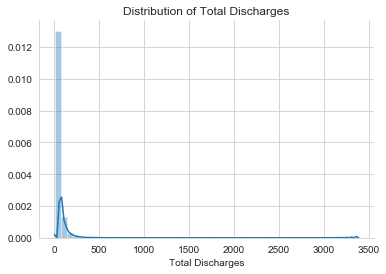

In [254]:
sns.distplot(df['Total Discharges'])
plt.title("Distribution of Total Discharges")
sns.despine()

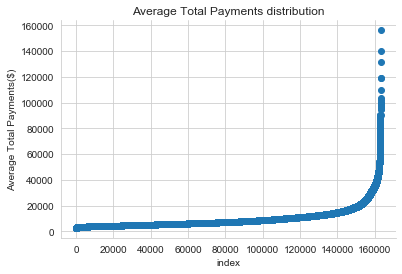

In [255]:
plt.scatter(range(df.shape[0]), np.sort(df['Average Total Payments($)'].values))
plt.xlabel('index')
plt.ylabel('Average Total Payments($)')
plt.title("Average Total Payments distribution")
sns.despine()

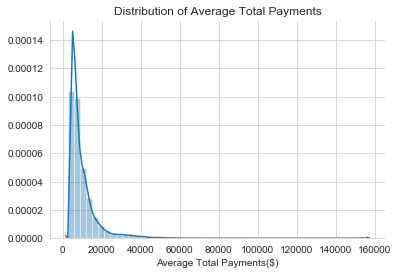

In [256]:
sns.distplot(df['Average Total Payments($)'])
plt.title("Distribution of Average Total Payments")
sns.despine()

#### Feature engineering
I will still use the features I created last week including mean_ratio_TotalDischarges, mean_ratio_AverageTotalPayments,mean_ratio_AverageMedicarePayments, median_ratio__TotalDischarges, median_ratio__AverageTotalPayments, median_ratio__AverageMedicarePayments (all these features have been grouped by DRG, State & city respectively) 

In [257]:
#benchmark for Average Medicare Payments($) named as 'Mean - Total Discharges'
table1 = df.groupby(['DRG Code','Provider State','Provider City'])['Total Discharges'].apply(lambda x : x.astype(float).mean())
df1 = table1.to_frame()
df1.reset_index(inplace=True)
df1 = df1.rename(columns={'Total Discharges': 'Mean - Total Discharges'})

In [258]:
#benchmark for Average Total Payments($) named as 'Mean - Average Total Payments($)'
table2 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Total Payments($)'].apply(lambda x : x.astype(float).mean())
df2 = table2.to_frame()
df2.reset_index(inplace=True)
df2 = df2.rename(columns={'Average Total Payments($)': 'Mean - Average Total Payments($)'})

In [259]:
#benchmark for Average Medicare Payments($) named as 'Mean - Average Medicare Payments($)'
table3 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Medicare Payments($)'].apply(lambda x : x.astype(float).mean())
df3 = table3.to_frame()
df3.reset_index(inplace=True)
df3 = df3.rename(columns={'Average Medicare Payments($)': 'Mean - Average Medicare Payments($)'})

In [260]:
#benchmark for Average Medicare Payments($) named as 'Mean - Total Discharges'
table4 = df.groupby(['DRG Code','Provider State','Provider City'])['Total Discharges'].apply(lambda x : x.astype(float).median())
df4 = table4.to_frame()
df4.reset_index(inplace=True)
df4 = df4.rename(columns={'Total Discharges': 'Median - Total Discharges'})

In [261]:
#benchmark for Average Total Payments($) named as 'Median - Average Total Payments($)'
table5 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Total Payments($)'].apply(lambda x : x.astype(float).median())
df5 = table5.to_frame()
df5.reset_index(inplace=True)
df5 = df5.rename(columns={'Average Total Payments($)': 'Median - Average Total Payments($)'})

In [262]:
#benchmark for Average Medicare Payments($) named as 'Median - Average Medicare Payments($)'
table6 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Medicare Payments($)'].apply(lambda x : x.astype(float).median())
df6 = table6.to_frame()
df6.reset_index(inplace=True)
df6 = df6.rename(columns={'Average Medicare Payments($)': 'Median - Average Medicare Payments($)'})

In [263]:
# merge benchmarks into the original dataset
df = pd.merge(df, df1, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df2, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df3, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df4, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df5, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df6, on=['DRG Code','Provider State','Provider City'], how='left')

In [264]:
#create new columns to derive the ratios
df['mean_ratio_AverageTotalPayments'] = df['Average Total Payments($)']/df['Mean - Average Total Payments($)']
df['mean_ratio_AverageMedicarePayments'] = df['Average Medicare Payments($)']/df['Mean - Average Medicare Payments($)']
df['mean_ratio_TotalDischarges'] = df['Total Discharges']/df['Mean - Total Discharges']
df['median_ratio__AverageTotalPayments'] = df['Average Total Payments($)']/df['Median - Average Total Payments($)']
df['median_ratio__AverageMedicarePayments'] = df['Average Medicare Payments($)']/df['Median - Average Medicare Payments($)']
df['median_ratio_TotalDischarges'] = df['Total Discharges']/df['Median - Total Discharges']

In [265]:
#extract columns we need for modeling 
model_columns =['mean_ratio_AverageTotalPayments','mean_ratio_AverageMedicarePayments','mean_ratio_TotalDischarges','median_ratio__AverageTotalPayments','median_ratio__AverageMedicarePayments','median_ratio_TotalDischarges']

In [266]:
##binning numeric variables
#binning: encoding each numerical features into 10 subgroups (0,10,20,30,40,50,60,70,80,90)
for col in model_columns:
    df[col] = pd.qcut(df[col], 10, duplicates='drop', labels=False)

#### Model for Anomaly Detection

#### Model 1: Autoencoder

In technical term, Autoencoders are a type of unsupervised neural network that can 1) accept an input set of data 2) internally compress the data into a latent-space representation 3) reconstruct the input data from the latent representation. It uses two components an encoder and a decoder. The encoder accepts the input data and compresses it into the latent-space representation. The decoder then attempts to reconstruct the input data from the latent space. 
This is why autoencoder neural network has the same number of neurons in the output layer as the input layer, which basically means that the number inputs and outputs are the same. 


How Autoencoder can detect anomalies: after the encoder has been trained to be able to recognize and reconstruct the normal data and learn to compress it into a small element and decode it back as the input with a small error. When we give an anomaly input to the model, it will be unable to resconstruct it(mean-squared-error (MSE) between the input image and the reconstructed image from the autoencoder will be very high). Therefore, what we need to do is calculate MSE of the output compared to input and to properly differentiate the anomalies, by checking the outputs we need to set a threshold value for MSE according to our need so that it predicts with good precision and recall.

###### Reference:
https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048

https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6

In [267]:
##to form a new dataframe 'dfae' exclusively for modelling
dfae = df[model_columns]

In [268]:
## before setting up the models, we need to define train/test data. (7:3)
from pyod.models.auto_encoder import AutoEncoder
from sklearn.model_selection import train_test_split 
dfae_train, dfae_test = train_test_split(dfae, test_size = 0.3 , random_state=42 )

In [269]:
# standardize data (scale the input variables of the model)
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(dfae_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(dfae_test)
X_test = pd.DataFrame(X_test)

In [270]:
X_train.shape

(114145, 6)

In [271]:
X_test.shape

(48920, 6)

In [272]:
X_train.describe()

,0,1,2,3,4,5
count,1.141450e+05,1.141450e+05,1.141450e+05,1.141450e+05,1.141450e+05,1.141450e+05
mean,4.599900e-16,-1.817980e-15,-1.195993e-15,-7.585412e-16,-1.502857e-15,-1.966127e-15
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.996293e+00,-1.997600e+00,-1.996595e+00,-1.594055e+00,-1.594464e+00,-1.589061e+00
25%,2.017439e-02,1.959852e-02,2.335028e-02,-2.461622e-01,-2.467045e-01,-2.398538e-01
50%,2.017439e-02,1.959852e-02,2.335028e-02,-2.461622e-01,-2.467045e-01,-2.398538e-01
75%,2.017439e-02,1.959852e-02,2.335028e-02,-2.461622e-01,-2.467045e-01,-2.398538e-01
max,2.036642e+00,2.036797e+00,2.043295e+00,2.449624e+00,2.448815e+00,2.458561e+00


In [273]:
# a 3-d space, dimmension reduction
from sklearn.decomposition import PCA
pca = PCA(3)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2','PC3']
x_pca.head()

,PC1,PC2,PC3
0,-3.510121,3.279146,0.131440
1,-0.233750,-0.158909,-0.056767
2,-0.233750,-0.158909,-0.056767
3,0.437941,-0.824759,-1.566869
4,4.479610,0.472834,-0.008648


###### Model 1

In [310]:
#### It is unsupervised learning, so it does not require target variable
#We will build three models: clf1, clf2, and clf3
#clf1 has hidden_neurons = [6, 2, 2, 6]
#clf2 has hidden_neurons = [6, 4, 2, 4, 6]
#clf3 has hidden_neurons = [6, 4, 2, 1, 2, 4, 6])
#The number of the hidden layers and the number of neutrons in a hidden layer: if there are too many hidden layers or too many neutrons, the model tends to overfit; otherwise the model tends to underfit.

####Build model
clf1 = AutoEncoder(hidden_neurons =[6, 2, 2, 6])
clf1.fit(X_train)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_78 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_79 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_91 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_80 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_92 (Dense)             (None, 2)               

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[6, 2, 2, 6],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x12f6fdb00>, optimizer='adam',
      output_activation='sigmoid', preprocessing=True, random_state=None,
      validation_size=0.1, verbose=1)

In [313]:
#"decision_functions()" predicts the outliers of a dataframe. A higher score means more abnormal.
#The histogram below shows there are outliers. If we choose 1.0 to be the cutpoint, we can suggest those >=1.0 to be outliers
y_train_scores = clf1.decision_scores_  # raw outlier scores
#y_train_scores

# get the prediction on the test data
y_test_pred = clf1.predict(X_test)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf1.decision_function(X_test)  # outlier scores

y_test_pred = pd.Series(y_test_pred)
y_test_scores = pd.Series(y_test_scores)

In [314]:
y_test_pred.value_counts()
# there are about 5000 anamolies

0    44044
1     4876
dtype: int64

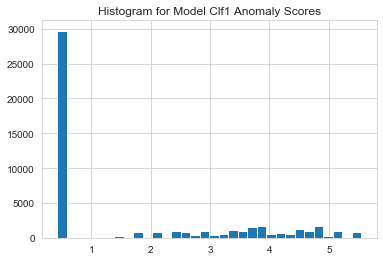

In [315]:
###step 2: Determine the Cut Point
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

I choose 1.0 to be the cut point and those >=1.0 to be outliers. Let’s assign those observations with less than 1.0 anomaly scores to Cluster 0, and to Cluster 1 for those above 1.0. This model has identified 19191 outliers.

In [316]:
###step 3: Get the Summary Statistics by Cluster
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster'].value_counts()

0    29729
1    19191
Name: cluster, dtype: int64

In [317]:
#We recommend observations in Cluster 1 to be outliers.
#The attributes of Cluster 1 are shown below.

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,score
cluster,,,,,,,
0,0.016823,0.019053,0.020948,-0.24636,-0.245066,-0.242109,0.425049
1,-0.026060,-0.029515,-0.032451,0.38164,0.379634,0.375054,3.735681


The size of anomalous cases: 19191 in count and 37.8% in %

###### model 2

In [321]:
clf2 = AutoEncoder(hidden_neurons =[6, 4, 2, 4, 6])
clf2.fit(X_train)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores2 = clf2.decision_function(X_test)  # outlier scores
y_test_scores2 = pd.Series(y_test_scores2)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_84 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_97 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_85 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_98 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_86 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_99 (Dense)             (None, 4)               

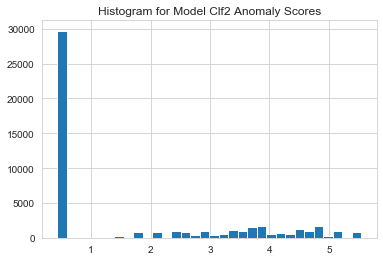

In [322]:
# determine the cut point 
import matplotlib.pyplot as plt
plt.hist(y_test_scores2, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

##still i use 1.0 as  cut point

In [323]:
###step 3: Get the Summary Statistics by Cluster
df_test = X_test.copy()
df_test['score2'] = y_test_scores2
df_test['cluster2'] = np.where(df_test['score2']<1, 0, 1)
df_test['cluster2'].value_counts()

0    29729
1    19191
Name: cluster2, dtype: int64

In [324]:
df_test.groupby('cluster2').mean()

,0,1,2,3,4,5,score2
cluster2,,,,,,,
0,0.016823,0.019053,0.020948,-0.24636,-0.245066,-0.242109,0.425369
1,-0.026060,-0.029515,-0.032451,0.38164,0.379634,0.375054,3.735615


The size of anomalous cases: 19191 in count and 37.8% in %

###### model 3

In [328]:
clf3 = AutoEncoder(hidden_neurons =[6, 4, 2, 1, 2, 4, 6])
clf3.fit(X_train)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores3 = clf3.decision_function(X_test)  # outlier scores
y_test_scores3 = pd.Series(y_test_scores3)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 6)                 42        
_________________________________________________________________
dropout_100 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_115 (Dense)            (None, 6)                 42        
_________________________________________________________________
dropout_101 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_116 (Dense)            (None, 6)                 42        
_________________________________________________________________
dropout_102 (Dropout)        (None, 6)                 0         
_________________________________________________________________
dense_117 (Dense)            (None, 4)               

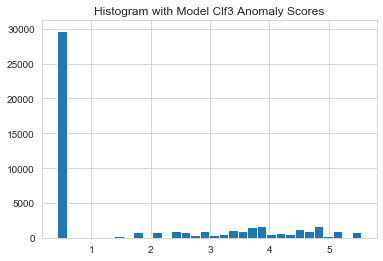

In [329]:
#determine the cut point
import matplotlib.pyplot as plt
plt.hist(y_test_scores3, bins='auto')  
plt.title("Histogram with Model Clf3 Anomaly Scores")
plt.show()

In [330]:
#step 3: Get the Summary Statistics by Cluster
df_test = X_test.copy()
df_test['score3'] = y_test_scores3
df_test['cluster3'] = np.where(df_test['score3']<1, 0, 1)
df_test['cluster3'].value_counts()

0    29729
1    19191
Name: cluster3, dtype: int64

In [331]:
df_test.groupby('cluster3').mean()

,0,1,2,3,4,5,score3
cluster3,,,,,,,
0,0.016823,0.019053,0.020948,-0.24636,-0.245066,-0.242109,0.425152
1,-0.026060,-0.029515,-0.032451,0.38164,0.379634,0.375054,3.735648


The size of anomalous cases: 19191 in count and 37.8% in %

##### Aggregate to Achieve Model Stability

In order to eliminate overfitting and unstable results, we need to train multiple models and then aggregate the scores. In the following steps, we will use four methods as below.
- Average: average scores of all detectors.
- Maximum of Maximum (MOM)

In [332]:
# put all the predictions of the above three models in a data frame.
from pyod.models.combination import aom, moa, average, maximization

train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

In [333]:
train_scores.head()

,clf1,clf2,clf3
0,4.825422,4.825173,4.824685
1,0.424895,0.425218,0.424996
2,0.424895,0.425218,0.424996
3,2.083759,2.083550,2.083858
4,4.627225,4.627323,4.627584


In [334]:
test_scores.head()

,clf1,clf2,clf3
0,4.848196,4.847946,4.847458
1,3.773997,3.773935,3.774076
2,0.425049,0.425369,0.425152
3,2.377104,2.376804,2.376632
4,2.377104,2.376804,2.376632


In [335]:
#standardize the scores ( output scores) from different models 
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
from sklearn.preprocessing import StandardScaler
train_scores_norm = StandardScaler().fit_transform(train_scores)
train_scores_norm = pd.DataFrame(train_scores_norm)
test_scores_norm = StandardScaler().fit_transform(test_scores)
test_scores_norm = pd.DataFrame(test_scores_norm)

In [336]:
train_scores_norm.shape

(114145, 3)

###### Average Method

The average() function computes the average of the outlier scores from multiple models.

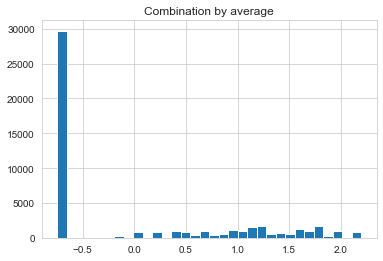

In [337]:
#Determine the cut point
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

It appears we can identify those >= -0.5 as the outliers. Our example identifies 19191 outliers (not shown).

In [338]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<-0.5, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    29729
1    19191
Name: y_by_average_cluster, dtype: int64

In [339]:
#Get the Summary Statistics by Cluster
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,y_by_average_score
y_by_average_cluster,,,,,,,
0,0.016823,0.019053,0.020948,-0.24636,-0.245066,-0.242109,-0.746276
1,-0.026060,-0.029515,-0.032451,0.38164,0.379634,0.375054,1.156065


The above code and results show the summary statistics of Cluster ‘1’ (the abnormal cluster) is different from those of Cluster ‘0’ (the normal cluster). The observations in Cluster 1 are outliers.

The size of anomalous cases: 19191 in count and 39.2% in % 

###### Maximum of Maximum Method （MOM)
Highest score for all detectors

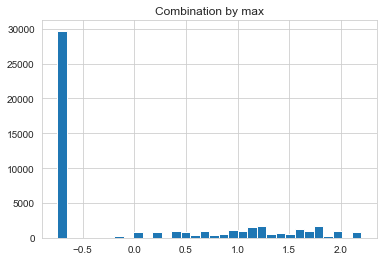

In [340]:
#determine the cut point
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [341]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<-0.5, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    29729
1    19191
Name: y_by_maximization_cluster, dtype: int64

In [342]:
df_test

,0,1,2,3,4,5,y_by_average_score,y_by_average_cluster,y_by_maximization_score,y_by_maximization_cluster
0,-2.010197,-2.007155,2.050214,-1.599295,-1.598335,2.472531,1.795197,1,1.795353,1
1,-2.010197,-0.994051,-2.008318,-1.599295,-0.245066,-1.599429,1.178105,1,1.178145,1
2,0.016823,0.019053,0.020948,-0.246360,-0.245066,-0.242109,-0.746276,0,-0.746269,0
3,1.030332,-0.994051,1.035581,1.106575,-0.245066,1.115211,0.375235,1,0.375409,1
4,1.030332,-0.994051,1.035581,1.106575,-0.245066,1.115211,0.375235,1,0.375409,1
...,...,...,...,...,...,...,...,...,...,...
48915,-0.996687,0.019053,-0.993685,-0.246360,2.461473,1.115211,0.765921,1,0.765992,1
48916,1.030332,1.032156,1.035581,1.106575,1.108204,1.115211,0.517968,1,0.517993,1
48917,2.043842,2.045260,-0.993685,2.459510,2.461473,-0.242109,1.674470,1,1.674648,1
48918,0.016823,0.019053,0.020948,-0.246360,-0.245066,-0.242109,-0.746276,0,-0.746269,0


In [343]:
#Get the Summary Statistics by Cluster
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,
0,0.016823,0.019053,0.020948,-0.24636,-0.245066,-0.242109,-0.746276,0,-0.746269
1,-0.026060,-0.029515,-0.032451,0.38164,0.379634,0.375054,1.156065,1,1.156195


The size of anomalous cases: 19191 in count and 38.7% in %

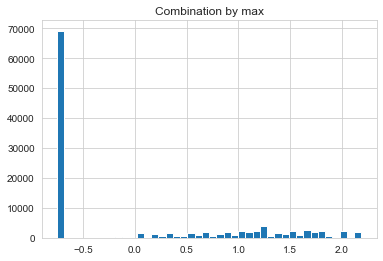

In [344]:
#####################################
#put the outlier column into he dataset 
y_by_maximization = maximization(train_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [345]:
df_train = pd.DataFrame(X_train)
df_train['y_by_maximization_score'] = y_by_maximization
df_train['y_by_maximization_cluster'] = np.where(df_train['y_by_maximization_score']<-0.5, 0, 1)
df_train['y_by_maximization_cluster'].value_counts()

0    69152
1    44993
Name: y_by_maximization_cluster, dtype: int64

In [346]:
##########merge train, test  together
anomaly_alldata = pd.concat([df_train, df_test])

In [347]:
#put the outlier column into he dataset 
df1 = df.copy()
df1['outlier'] =  anomaly_alldata['y_by_maximization_cluster'].tolist()

In [348]:
####exttract all outliers out and form a dataset conttainig only outliers
dfae_outliers = df1.loc[df1['outlier'] == 1]

In [349]:
dfae_outliers.describe(include=['O'])

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,DRG Code
count,64184,64184,64184,64184,64184,64184,64184,64184,64184
unique,100,3231,3100,3221,1942,51,2985,306,100
top,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",490112,GOOD SAMARITAN HOSPITAL,100 MEDICAL CENTER DRIVE,CHICAGO,CA,76104,CA - Los Angeles,392
freq,1187,53,253,75,587,5144,120,1426,1187


Insights:

The size of anomalous cases: 64184 in count and 39.4% in %.

a) 392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISEASE is the most common DRG used for frauds by providers

b) GOOD SAMARITAN HOSPITAL commit frauds most often 

c) Most of frauds happend in CA

#### Model2 :iForest

Isolation Forest isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data. Unlike autoencoder, isolation forest algorithm does not first define "normal" behavior, and it does not calculate point-based distances. It works by recursively generating partitions on the dataset by randomly selecting a feature and then randomly selecting a split value for the feature.Presumably the anomalies need fewer random partitions to be isolated compared to "normal" points in the dataset, so the anomalies will be the points which have a smaller path length in the tree, path length being the number of edges traversed from the root node.

reference:

https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08

https://blog.paperspace.com/anomaly-detection-isolation-forest/

https://medium.com/@often_weird/isolation-forest-algorithm-for-anomaly-detection-f88af2d5518d

https://medium.com/@often_weird/isolation-forest-algorithm-for-anomaly-detection-f88af2d5518d

In [174]:
##to form a new dataframe 'dfif' exclusively for modelling
dfif = df[model_columns]

In [177]:
#When we do unsupervised learning, it is always a safe step to standardize the predictors
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(dfif)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5
0,1.028979,1.029380,2.045358,1.103179,1.103191,2.462725
1,0.019172,0.019435,0.022632,-0.246221,-0.246214,-0.240527
2,0.019172,0.019435,0.022632,-0.246221,-0.246214,-0.240527
3,-0.990634,-2.000453,-0.988731,-0.246221,-0.246214,-0.240527
4,0.019172,0.019435,0.022632,-0.246221,-0.246214,-0.240527


In [179]:
## before setting up the models, we need to define train/test data. (7:3)
from sklearn.model_selection import train_test_split 
X_train, X_test = train_test_split(X, test_size = 0.3 , random_state=42)

In [180]:
print(X_train.shape); print(X_test.shape)

(114145, 6)
(48920, 6)


In [182]:
#Plot in a 2-D space just to visualize it
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
x_pca.head()

,PC1,PC2
0,2.209089,3.138601
1,-0.233958,-0.159891
2,-0.233958,-0.159891
3,-1.749947,-0.765966
4,-0.233958,-0.159891


In [184]:
len(dfif)

163065

Modelling: iForest

We do not need the target variable to train the unsupervised learning model.

We will create three models: clf1, clf2,and clf3

our data has 100,000+ samples, you can set the max_samples to be anywhere between 100 and 100,000.

Model 1: max_samples = 10000

Model 2: max_samples = 8000

Model 3: max_samples = 600

###### Model 1

In [187]:
from pyod.models.iforest import IForest
clf1 = IForest(behaviour="new", max_samples=10000) 
clf1.fit(X_train)
#After modeling, there is an anomaly score for each observation in the training dataset X_Train.

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=10000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [191]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.096063
1   -0.027641
2   -0.237724
3   -0.080998
4   -0.080998
dtype: float64

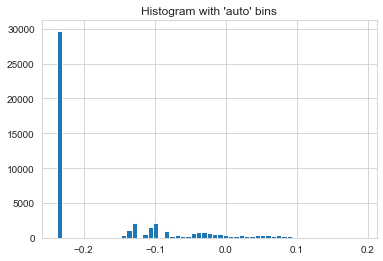

In [192]:
#determine the cut point
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [193]:
#A high anomaly score means more abnormal. We can suggest those >=-0.2 to be outliers
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<-0.2, 0, 1)
X_test_cluster['cluster'].value_counts()

1    39986
0     8934
Name: cluster, dtype: int64

In [194]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,distance
cluster,,,,,,,
0,0.006287,-0.001365,0.021500,0.001637,-0.005756,0.020903,-0.237724
1,0.001545,0.000846,-0.002661,-0.000983,-0.000975,-0.003977,-0.045483


###### Model 2

In [196]:
clf2 = IForest(behaviour="new", max_samples=8000) 
clf2.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=8000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [197]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.097246
1   -0.021719
2   -0.240483
3   -0.073307
4   -0.073307
dtype: float64

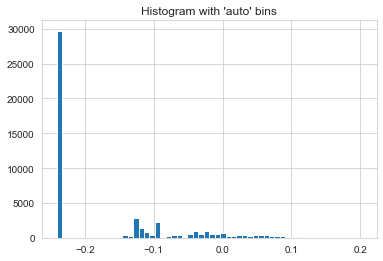

In [198]:
#determine the cut point
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram with 'auto' bins")
plt.show()

In [199]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<-0.2, 0, 1)
X_test_cluster['cluster'].value_counts()

1    39986
0     8934
Name: cluster, dtype: int64

In [200]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,distance
cluster,,,,,,,
0,0.006287,-0.001365,0.021500,0.001637,-0.005756,0.020903,-0.240483
1,0.001545,0.000846,-0.002661,-0.000983,-0.000975,-0.003977,-0.046871


###### Model 3

In [201]:
clf3 = IForest(behaviour="new", max_samples=600) 
clf3.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=600, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [202]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf3.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.077097
1    0.004678
2   -0.277145
3   -0.035381
4   -0.035381
dtype: float64

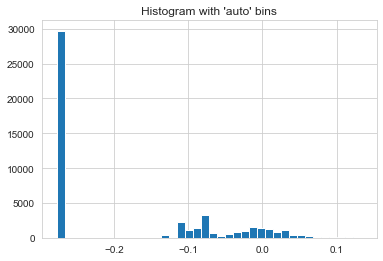

In [203]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [204]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<-0.2, 0, 1)
X_test_cluster['cluster'].value_counts()

1    39986
0     8934
Name: cluster, dtype: int64

In [205]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,distance
cluster,,,,,,,
0,0.006287,-0.001365,0.021500,0.001637,-0.005756,0.020903,-0.277145
1,0.001545,0.000846,-0.002661,-0.000983,-0.000975,-0.003977,-0.040079


The size of anomalous cases(in test set): 8934 in count and 18.3% in %. We recommend observations in Cluster 1 to be outliers. The average "distance" indicates the distances of those points in Cluster 1. The distance of Cluster 1 is higher than that of Cluster 0, meaning points in Cluster 1 are far away from other points.

##### Achieve Model Stability by Aggregating Multiple Models



In order to eliminate overfitting and unstable results, we need to train multiple models and then aggregate the scores. In the following steps, we will use four methods as below.
- Average: average scores of all detectors.
- Maximum of Maximum (MOM)
- Average of Maximum (AOM)
- Maximum of Average (MOA)

In [206]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

In [207]:
#Put all the predictions in a data frame
#The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

In [208]:
train_scores.head()

,clf1,clf2,clf3
0,-0.096063,-0.097246,-0.077097
1,-0.237724,-0.240483,-0.277145
2,-0.237724,-0.240483,-0.277145
3,-0.078649,-0.070734,-0.036908
4,-0.029860,-0.034829,-0.021801


In [211]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

In [212]:
train_scores_norm.shape

(114145, 3)

###### Average

In [214]:
#The "average" function in PyOD averages the outlier scores from multiple estimators.
# Combination by average
y_by_average = average(test_scores_norm)

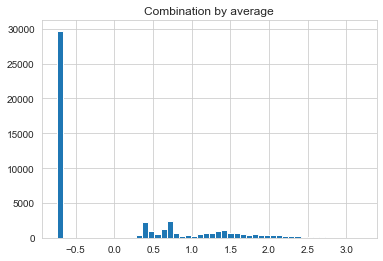

In [215]:
##determine the cut point
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto') 
plt.title("Combination by average")
plt.show()

In [216]:
##It appears we can identify those >=0 as the outliers
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0.0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    29729
1    19191
Name: y_by_average_cluster, dtype: int64

In [217]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,y_by_average_score
y_by_average_cluster,,,,,,,
0,0.019172,0.019435,0.022632,-0.246221,-0.246214,-0.240527,-0.741892
1,-0.023554,-0.028981,-0.030595,0.380138,0.376702,0.374047,1.141182


###### Maximum of maximum

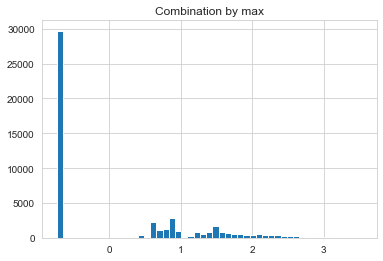

In [218]:
#determine the cut point
# Combination by max
y_by_maximization = maximization(test_scores_norm)

plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [219]:
##It appears we can identify those >=0 as the outliers
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    29729
1    19191
Name: y_by_maximization_cluster, dtype: int64

In [220]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,
0,0.019172,0.019435,0.022632,-0.246221,-0.246214,-0.240527,-0.741892,0,-0.724961
1,-0.023554,-0.028981,-0.030595,0.380138,0.376702,0.374047,1.141182,1,1.312664


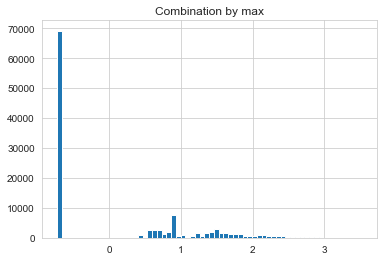

In [224]:
#####################################
#put the outlier column into the dataset 
y_by_maximization = maximization(train_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [226]:
##It appears we can identify those >=0 as the outliers
df_train = pd.DataFrame(X_train)
df_train['y_by_maximization_score'] = y_by_maximization
df_train['y_by_maximization_cluster'] = np.where(df_train['y_by_maximization_score']<0, 0, 1)
df_train['y_by_maximization_cluster'].value_counts()

0    69152
1    44993
Name: y_by_maximization_cluster, dtype: int64

In [227]:
anomaly_alldata = pd.concat([df_train, df_test])

In [244]:
#put the outlier column into he dataset 
df2 = df.copy()
df2['outlier'] =  anomaly_alldata['y_by_maximization_cluster'].tolist()

In [245]:
####exttract all outliers out and form a dataset conttainig only outliers
dfif_outliers = df2.loc[df2['outlier'] == 1]

In [246]:
dfif_outliers.describe(include=['O'])

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,DRG Code
count,64184,64184,64184,64184,64184,64184,64184,64184,64184
unique,100,3231,3100,3221,1942,51,2985,306,100
top,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",490112,GOOD SAMARITAN HOSPITAL,100 MEDICAL CENTER DRIVE,CHICAGO,CA,76104,CA - Los Angeles,392
freq,1187,53,253,75,587,5144,120,1426,1187


Insights:

The size of anomalous cases: 64184 in count and 39.4% in %.

a) 392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DISEASE is the most common DRG used for frauds by providers

b) GOOD SAMARITAN HOSPITAL commit frauds most often

c) Most of frauds happend in CA